In [ ]:
import os
import sys
import time
import pickle
import datetime as dt
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from sklearn.metrics import mean_squared_error

root_dir = '/srv/scratch/z5370003/projects/DeepGR4J-Extremes'
sys.path.append(root_dir)

from model.tf.ml import ConvNet, LSTM
from model.tf.hydro import ProductionStorage
from data.tf.camels_dataset import CamelsDataset, HybridDataset
from utils.training import EarlyStopper, Trainer
from utils.evaluation import nse, normalize

2024-10-01 18:56:09.496491: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-01 18:56:10.610942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 18:56:10.841020: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 18:56:10.847721: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 18:56:11.014630: I tensorflow/core/platform/cpu_feature_guar

In [2]:
ts_input_dim = 6
hidden_dim = 32
lstm_dim = 64
n_layers = 4
ts_output_dim = 8
dropout = 0.2

window_size = 8
n_features = 6
n_channels = 1
out_dim = 1
n_filters = [16, 16, 8]
cnn_dropout = 0.1

static_input_dim = 7
static_hidden_dim = 64
static_output_dim = 8

combined_hidden_dim = 64

In [4]:
target_vars = ['flow_cdf']

In [7]:
def get_model():
    ts_model_name = 'lstm'
    if ts_model_name == 'lstm':
        ts_model = LSTM(window_size=window_size,
                    input_dim=ts_input_dim,
                    hidden_dim=hidden_dim,
                    lstm_dim=lstm_dim,
                    n_layers=n_layers,
                    output_dim=ts_output_dim,
                    dropout=dropout)
    
    elif ts_model_name == 'cnn':
        ts_model = ConvNet(n_ts=window_size,
                           n_features=n_features,
                           n_channels=n_channels,
                           out_dim=out_dim,
                           n_filters=n_filters,
                           dropout_p=cnn_dropout)

    static_model = tf.keras.Sequential([
                        tf.keras.layers.Dense(static_hidden_dim, activation='tanh'),
                        tf.keras.layers.Dense(static_hidden_dim, activation='tanh'),
                        tf.keras.layers.Dense(static_output_dim, activation='relu')
                    ])

    # Define input layers
    if ts_model_name == 'lstm':
        timeseries = tf.keras.Input(shape=(window_size, ts_input_dim), name='timeseries')
    elif ts_model_name == 'cnn':
        timeseries = tf.keras.Input(shape=(window_size, ts_input_dim, 1), name='timeseries')
    else:
        print(ts_model_name)
    static = tf.keras.Input(shape=(static_input_dim,), name='static')

    # Combine inputs
    relu = tf.keras.layers.Activation('relu')
    ts_hidden = relu(ts_model(timeseries))
    static_hidden = static_model(static)
    concatenated = tf.keras.layers.Concatenate()([ts_hidden, static_hidden])

    # Dense model
    hidden = tf.keras.layers.Dense(combined_hidden_dim, activation='tanh')(concatenated)
    hidden = tf.keras.layers.Dense(combined_hidden_dim, activation='tanh')(hidden)
    output = tf.keras.layers.Dense(len(target_vars), activation='linear')(hidden)

    model_combined = tf.keras.Model(inputs=[timeseries, static],
                                    outputs=output)
    return model_combined

In [8]:
model = get_model()

In [10]:
model_path = '../results/flow_cdf_saved_w8/QLD_54/model.keras'
model.load_weights(model_path)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ timeseries          │ (None, 8, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 8)         │     24,616 │ timeseries[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static (InputLayer) │ (None, 7)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 8)         │          0 │ lstm[0][0]        │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 8)         │      5,192 │ static[0][0]      │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16)        │          0 │ activation[0][0], │
│ (Concatenate)       │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      1,088 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,121 (137.19 KB)

 Trainable params: 35,121 (137.19 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
camels_dir = '../../data/camels/aus/'
scalers_path = '../results/flow_cdf_saved_w8/QLD_54/scalers.pkl'

camels_ds = CamelsDataset(data_dir=camels_dir, 
                          target_vars=target_vars,
                          window_size=window_size)

camels_ds.load_scalers(scalers_path)
camels_ds.prepare_data(station_list=['102101A']) #state_outlet='QLD', map_zone=54)
train_ds, test_ds = camels_ds.get_datasets()

In [13]:
def plot_timeseries(model, dl):
    preds = []
    true = []
    stations = []
    for step, batch in enumerate(dl):
        out = model([batch['timeseries'], batch['static']],
                     training=False) 
        preds.append(out)
        true.append(batch['target'])
        stations.append(batch['station_id'])
    preds = tf.concat(preds, axis=0)
    true = tf.concat(true, axis=0)
    stations = tf.concat(stations, axis=0)

    # Convert to numpy array
    preds = camels_ds.target_scaler.inverse_transform(preds.numpy())
    true = camels_ds.target_scaler.inverse_transform(true.numpy())
    stations = stations.numpy().flatten()

    # os.makedirs(results_dir, exist_ok=True)
    mse_error = {}

    for station in np.unique(stations):
        idx = (stations==station)
        station = station.decode('utf-8')
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(preds[idx, -1], label='pred')
        ax.plot(true[idx, -1], label='true')
        mse_error[station] = mean_squared_error(true[idx, -1], preds[idx, -1])
        plt.legend()
    
    return mse_error, preds

2024-09-21 10:41:24.553630: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


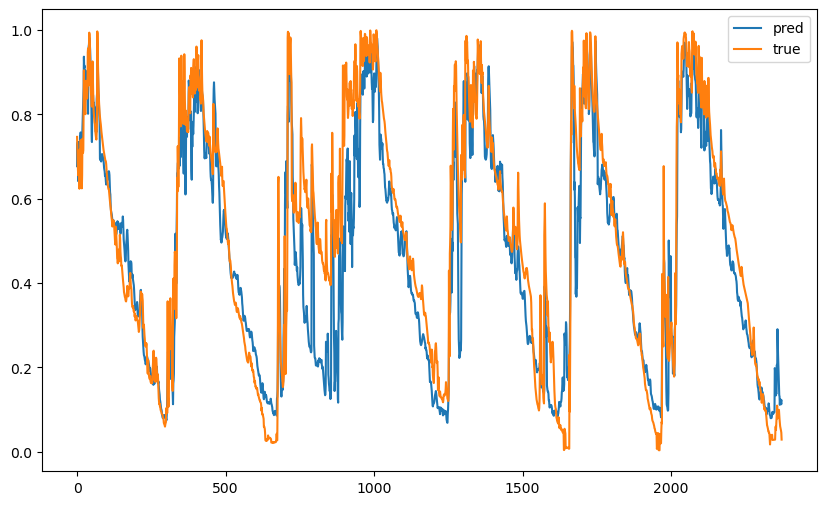

In [14]:
_, cdfpreds = plot_timeseries(model, test_ds.batch(256))

In [17]:
ts_input_dim = 10
hidden_dim = 32
lstm_dim = 64
n_layers = 4
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
dropout = 0.2

In [18]:
# prod_path = '../results/qdeepgr4j_saved/aus/model/102101A/prod.keras'
prod = ProductionStorage()
# prod.load_weights(prod_path)
# prod.x1.numpy()

In [20]:
qmodel = LSTM(window_size=window_size,
              input_dim=ts_input_dim,
              hidden_dim=hidden_dim,
              lstm_dim=lstm_dim,
              n_layers=n_layers,
              output_dim=len(quantiles),
              dropout=dropout)

In [30]:
gr4j_logfile = '../results/gr4j/result.csv'
hybrid_ds_scalers_path = '../results/qdeepgr4j_5q_w8/aus/model/102101A/scalers.pkl'

hybrid_ds = HybridDataset(data_dir=camels_dir,
                          gr4j_logfile=gr4j_logfile,
                          prod=prod,
                          window_size=window_size,
                          target_vars=['streamflow_mmd'])

hybrid_ds.load_scalers(hybrid_ds_scalers_path)
hybrid_ds.prepare_data(station_list=['102101A'])
hybrid_train_ds, hybrid_test_ds = hybrid_ds.get_datasets()

In [34]:
hybrid_len = 0
for batch in hybrid_test_ds.batch(256):
    hybrid_len += len(batch['timeseries'])
hybrid_len

2373

In [35]:
ds_len = 0
for batch in test_ds.batch(256):
    ds_len += len(batch['timeseries'])
ds_len

2373

In [29]:
def generate_predictions(model, dl):
    preds = []
    true = []
    stations = []
    for step, batch in enumerate(dl):
        out = model(batch['timeseries'],
                    training=False) 
        preds.append(out)
        true.append(batch['target'])
        stations.append(batch['station_id'])
    preds = tf.concat(preds, axis=0)
    true = tf.concat(true, axis=0)
    stations = tf.concat(stations, axis=0)

    # Convert to numpy array
    preds = hybrid_ds.target_scaler.inverse_transform(preds.numpy())
    true = hybrid_ds.target_scaler.inverse_transform(true.numpy())

    # Clip negative values
    preds = np.clip(preds, 0, None)
    stations = stations.numpy().flatten()

    mse_score = {}
    nse_score = {}
    nnse_score = {}

    for station in np.unique(stations):
        idx = (stations==station)
        station = station.decode('utf-8')
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(preds[idx, -2], label='pred', c='red')
        ax.plot(true[idx, -1], label='true', c='black')
        ax.fill_between(range(len(preds)), preds[:, 0], preds[:, -1], alpha=0.5, color='green')
        mse_score[station] = mean_squared_error(true[idx, -1], preds[idx, -2])
        nse_score[station] = nse(true[idx, -1], preds[idx, -2])
        nnse_score[station] = normalize(nse_score[station])
        
        plt.legend()
        # plt.savefig(os.path.join(results_dir, f'{station.decode("utf-8")}.png'))
        # plt.close()
    
    return mse_score, nse_score, nnse_score, preds, true

In [30]:
qmodel_path = '../results/qdeepgr4j_saved/aus/model/102101A/model.keras'
qmodel.load_weights(qmodel_path)
qmodel.summary()

Model: "lstm_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ ((256, 8, 64), (256,   │        19,200 │
│                                 │ 64), (256, 64))        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (256, 192)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (256, 32)              │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (256, 3)               │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (256, 192)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,475 (99.51 KB)

 Trainable params: 25,475 (99.51 KB)

 Non-trainable params: 0 (0.00 B)

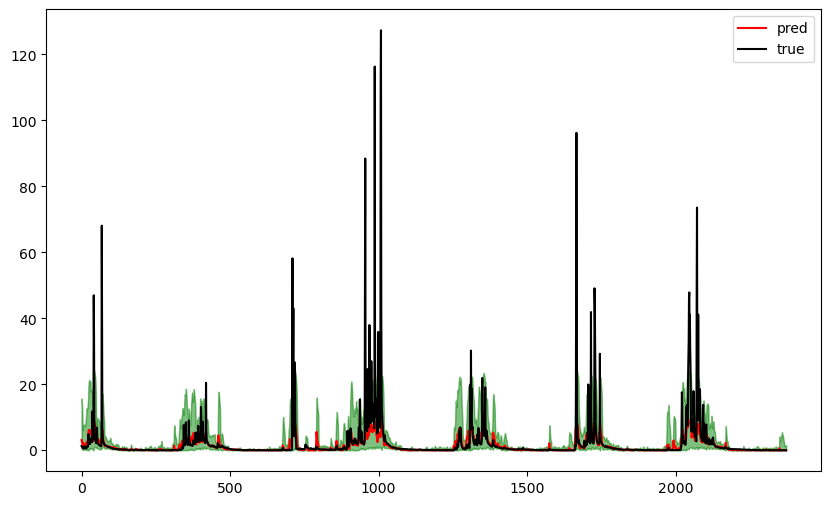

In [38]:
mse_score, nse_score, nnse_score, qpreds, true = generate_predictions(qmodel, hybrid_test_ds.batch(256))

In [79]:
def round_to_nearest(values):
    indices = np.ones_like(values)
    indices[values >= 0.95] = 2
    indices[values <= 0.05] = 0
    return indices.astype(int).flatten()

In [80]:
idx = round_to_nearest(cdfpreds)

In [81]:
def select_by_index(index_array, values_array):
    # Use numpy's advanced indexing to select the values
    selected_values = values_array[np.arange(len(index_array)), index_array]
    return selected_values

In [82]:
flowpreds = select_by_index(idx, qpreds)

In [83]:
nse_score, nnse_score

({'102101A': 0.21178394556045532}, {'102101A': 0.5592165429436411})

In [87]:
nse_score_corrected = nse(true.flatten(), flowpreds)
nnse_score_corrected = normalize(nse(true.flatten(), flowpreds))
nse_score_corrected, nnse_score_corrected

(0.28748029470443726, 0.5839348866513688)